# Weekly demand graph

In [1]:
import pandas as pd
trip_path = 'tripdata_excerpt_2011-2-1_2011-2-28_ids.csv'
df_demand = pd.read_csv(trip_path, index_col="pickup_datetime",  parse_dates = True, comment = "#")

### Select first week of February 2011

In [2]:
df_demand_7 = df_demand.loc['2011-02-01 00:00:00':'2011-02-08 00:00:00'][["passenger_count"]]
df_demand_7.head()

,passenger_count
pickup_datetime,
2011-02-01,1
2011-02-01,1
2011-02-01,1
2011-02-01,1
2011-02-01,2


In [3]:
print("Number of passengers:", df_demand_7['passenger_count'].sum())

Number of passengers: 2824061


### Group demand according to batch size

In [4]:
# Group demand (passengers and requests) in 30s bins
sum_30 = df_demand_7.passenger_count.resample('30s').sum()
count_30 = df_demand_7.passenger_count.resample('30s').count()

In [5]:
# Python graphs: https://python-graph-gallery.com/
# Visualization with matplotlib: https://www.oreilly.com/library/view/python-data-science/9781491912126/ch04.htmlimport matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from pprint import pprint
from scipy.ndimage.filters import gaussian_filter1d
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
%matplotlib inline
import os

sns.set()

def plot_vehicle_status_graph(instances_folder,
                              result_folder,
                              name_fig,
                              df = None,
                              replace = True,
                              smooth=None,
                              print_details = True,
                              fontsize = 'small',
                              fontsize_label = 'small',
                              show_tick_label_x = False,
                              label_y = (None, None, 'small'),
                              horizontal_legend = False,
                              fig_type = 'png',
                              custom_tw = (None, None),
                              day_sep_config = (None, None),
                              size_inches = (18,3),
                              nbins_y = 5,
                              context_font_scale = 1,
                              x_data_format = ('1h', '%H'),
                              color_bg = "#FFE4E1",
                              print_details_axis = (None, None),
                              input_dic = None,
                              show_week_days = False,
                              show_day_separator = True,
                              linewidth = 1.5,
                              tick_length = 3,
                              max_passenger = None,
                              show_service_rate = "Service rate: ",
                              style_plot = {'alpha':0.4, 'linewidth':0, 'colors' : [sns.xkcd_rgb['denim blue']]},
                              msg = None,
                             count_passengers = False):
    
    tw = 30
    th = 604800
    df_demand_7 = df.loc['2011-02-01 00:00:00':'2011-02-08 00:00:00'][["passenger_count"]]
    
    if count_passengers == True:
        if max_passenger:
            df_demand_7 = df_demand_7[df_demand_7['passenger_count'] <=max_passenger]
        sum_30 = df_demand_7.passenger_count.resample('30s').sum()
    else:
        sum_30 = df_demand_7.passenger_count.resample('30s').count()
    
    # Standard data frequency
    # E.g., freq = {10min, 6h, 1d}, format = {'%H:%M', '%H'}
    x_freq, x_format = x_data_format
    
    # Get custom time window (.e.g., ('2011-02-01T00:00:00', '2011-02-06T00:00:00'))
    custom_tw_min, custom_tw_max = custom_tw
    
    
    # X series (dates)
    if not custom_tw_min:
        x_min = datetime.strptime('2011-02-01T00:00:00','%Y-%m-%dT%H:%M:%S')
    else:
        x_min = datetime.strptime(custom_tw_min,'%Y-%m-%dT%H:%M:%S')
    
    if not custom_tw_max:
        x_max = datetime.strptime(str(dic_th[th][1])[:-10],'%Y-%m-%dT%H:%M:%S')
    else:
        x_max = datetime.strptime(custom_tw_max, '%Y-%m-%dT%H:%M:%S')
        
    x_start = x_min + timedelta(seconds = tw)
    x_end = x_max + timedelta(seconds = tw)
    
    x_last_req = x_min + timedelta(seconds = th) + timedelta(seconds = tw)
    
    rangeDates = pd.date_range(start=x_start,
                               end=x_end,
                               freq=x_freq)
    
    rangeDatesLabel = [str(int(d.strftime(x_format))) for d in rangeDates]
    
    
    print("TW:", x_min, x_max)
    

    x = sum_30.index.values
    y = sum_30.values
    
    # Define limits of y (before smoothing)
    ymin = 0
    ymax = max(y)

    # Smoth lines in y
    if smooth:
        y = gaussian_filter1d(y, sigma=smooth)


    
    YlGnBu_r = ['#081d58', '#e31a1c', '#225ea8', '#1d91c0', '#7fcdbb', '#c7e9b4', '#ffffd9']

    sns.set_palette(YlGnBu_r)
    #sns.set_style("ticks", {"xtick.major.size": 8, "axes.grid":True, 'axes.facecolor':'#d0d0dd','grid.color': '1.0'})
    sns.set_style("ticks", {"xtick.major.size": 8, "axes.grid":True, 'axes.facecolor':'1.0','grid.color': '0.9'})
    sns.set_context('notebook', font_scale = context_font_scale)
    print("Range: ", rangeDates)
    plt.xlim(min(x), rangeDates[-1])
    
    
    # Plot
    plt.stackplot(x, y, **style_plot)
    #plt.stackplot(x, y, labels=graph_legend, linewidth=0.01, edgecolor='white')
    #plt.stackplot(x, y, labels=graph_legend, linewidth=0.00)#, edgecolor='white')
    
    # Define and format
    # https://matplotlib.org/api/_as_gen/matplotlib.pyplot.xticks.html
    # {size in points, 'xx-small', 'x-small', 'small', 'medium', 'large', 'x-large', 'xx-large'}
    ticks_x = []
    if show_tick_label_x:
        ticks_x = rangeDatesLabel
        
    l_y, t_y, fontsize = label_y

    if l_y is not None:
        plt.yticks(l_y,t_y,fontsize=fontsize)
        plt.ylim(l_y[0], l_y[-1])
        print("LIMITS:", l_y[0], l_y[-1])
    else:
        plt.yticks(fontsize=fontsize)
        plt.locator_params(axis='y', nbins = nbins_y)
        
        
    plt.xticks(rangeDates, ticks_x, fontsize=fontsize)
    
    # https://matplotlib.org/api/axis_api.html#matplotlib.axis.Axis.set_tick_params
    ax = plt.gca()
    t_width = linewidth
    ax.tick_params(width = t_width, length= tick_length)
    ax.spines['top'].set_linewidth(t_width)
    ax.spines['right'].set_linewidth(t_width)
    ax.spines['bottom'].set_linewidth(t_width)
    ax.spines['left'].set_linewidth(t_width)
    
    # Print x, y axis labels
    det_x, det_y = print_details_axis
    if det_x:
        plt.xlabel(det_x, fontweight='bold', fontsize=fontsize_label)
    if det_y:
        plt.ylabel(det_y, fontweight='bold', fontsize=fontsize_label)
    
    if print_details:
    
        # Position legend (Source: https://matplotlib.org/api/legend_api.html?highlight=legend#module-matplotlib.legend)
        legend = None
        # https://pythonspot.com/matplotlib-legend/
        if horizontal_legend:
            legend = plt.legend(loc = "upper center",
                   bbox_to_anchor=(0.5, -0.1),
                   ncol=len(graph_legend),
                   fontsize=fontsize,
                   edgecolor="white",
                   title="Vehicle status:")
        else:
            legend = plt.legend(loc = "upper left",
                   bbox_to_anchor=(1, 1),
                   ncol=1,
                   fontsize=fontsize,
                   edgecolor="white",
                   title="Vehicle status:")
        
        legend.get_title().set_fontsize(fontsize_label) #legend 'Title' fontsize
    
    # Line defining TW
    #plt.axvline(x = x_last_req, linewidth=1, color='r', linestyle='--')    
    
    
    if show_week_days:
        # First date week
        week_day = x_min + timedelta(hours = 10)

        # Loop days of the week
        diff_days = x_end - x_start
        print("DAYS:", diff_days)
        print(diff_days.total_seconds(), diff_days.total_seconds()/(24*3600))

        for i in range(0,7):

            # Print week day
            plt.text(week_day,
                 l_y[-1]+10,
                 week_day.strftime("%a"),
                 fontsize=fontsize_label,
                 bbox=dict(boxstyle='square,pad=0.0',
                           fc='none',
                           ec='none'))

            week_day = week_day + timedelta(hours = 24)

    if show_day_separator:
        # Print day separator
        back_day_sep_dic, front_day_sep_dic = day_sep_config

        # Day of the week line separator
        dashed_line = x_min

        for i in range(0,6):

            # Print day separator
            dashed_line = dashed_line + timedelta(hours = 24)

            if back_day_sep_dic:
                back_day_sep_dic["x"] = dashed_line
                # White box below dashed line for constrast
                plt.axvline(**back_day_sep_dic)

            if front_day_sep_dic:
                front_day_sep_dic["x"] = dashed_line
                # Dashed line to separate week days
                plt.axvline(**front_day_sep_dic)
    
    # Remove white margins
    plt.margins(0,0)
    
    # PRINT SERVICE RATE
    # String format - https://docs.python.org/2/library/string.html#formatstrings
    # font - https://matplotlib.org/gallery/text_labels_and_annotations/fonts_demo_kw.html
    # size - {size in points, 'xx-small', 'x-small', 'small', 'medium', 'large', 'x-large', 'xx-large'}        

    if msg:
        msg_text, msg_fontsize = msg
        at = AnchoredText(msg_text,
                 prop=dict(fontstyle='italic',
                 fontsize=msg_fontsize,
                 transform=ax.transAxes,
                 bbox=dict(boxstyle='square,pad=0.0',
                           alpha=0.5,
                           fc='none',
                           ec='none')), frameon=True, loc='upper left', pad=0.0, borderpad=0.5)
        
        at.patch.set_boxstyle("square,pad=0.0")
        at.patch.set_ec('none')
        at.patch.set_fc('none')
        ax.add_artist(at)

    
    # Remove white margins
    plt.margins(0,0)
    
    fig = plt.gcf()
    fig.set_size_inches(size_inches[0], size_inches[1])
    
    #plt.savefig("{}{}".format(result_folder, name_fig), bbox_inches="tight", pad_inches=0)

    
    plt.savefig("{}{}".format(result_folder, name_fig), bbox_inches="tight")

  
  
    # pprint(df_status)

## Paper

TW: 2011-02-01 00:00:00 2011-02-08 00:00:00
Range:  DatetimeIndex(['2011-02-01 00:00:30', '2011-02-01 04:00:30',
               '2011-02-01 08:00:30', '2011-02-01 12:00:30',
               '2011-02-01 16:00:30', '2011-02-01 20:00:30',
               '2011-02-02 00:00:30', '2011-02-02 04:00:30',
               '2011-02-02 08:00:30', '2011-02-02 12:00:30',
               '2011-02-02 16:00:30', '2011-02-02 20:00:30',
               '2011-02-03 00:00:30', '2011-02-03 04:00:30',
               '2011-02-03 08:00:30', '2011-02-03 12:00:30',
               '2011-02-03 16:00:30', '2011-02-03 20:00:30',
               '2011-02-04 00:00:30', '2011-02-04 04:00:30',
               '2011-02-04 08:00:30', '2011-02-04 12:00:30',
               '2011-02-04 16:00:30', '2011-02-04 20:00:30',
               '2011-02-05 00:00:30', '2011-02-05 04:00:30',
               '2011-02-05 08:00:30', '2011-02-05 12:00:30',
               '2011-02-05 16:00:30', '2011-02-05 20:00:30',
               '2011-02-06 00:00:

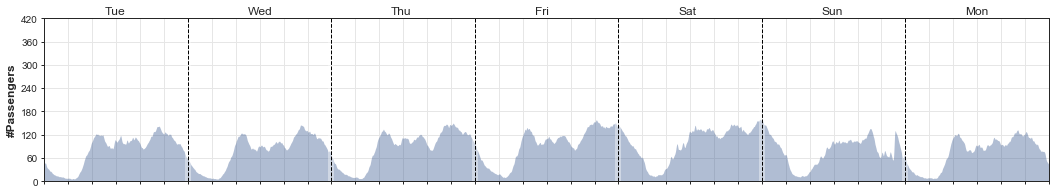

In [11]:
general_config = dict(replace=True,
                    smooth=10,
                    df = df_demand,
                    label_y = ([0, 60, 120, 180, 240, 300, 360, 420], [0, 60, 120, 180, 240, 300, 360, 420], "small"),
                    print_details=False,
                    size_inches = (18,3),
                    fontsize="medium",
                    fontsize_label="medium",
                    custom_tw = ('2011-02-01T00:00:00', '2011-02-08T00:00:00'),
                    x_data_format = ('4h', '%H'),
                    color_bg = "#C0C0C0",
                    horizontal_legend = True,
                    day_sep_config = (dict(linewidth=6, color='white', alpha=0.4), dict(linewidth=1, color='black', linestyle='--')),
                    fig_type = 'pdf',
                    linewidth = 1)
msg_fontsize = 'large'
plot_vehicle_status_graph(trip_path,
                            "./",
                            "demand.pdf",
                            show_week_days = True,
                            show_service_rate = True,
                            print_details_axis = (None, "#Passengers"),
                            **general_config)

## Presentation

TW: 2011-02-01 00:00:00 2011-02-08 00:00:00
Range:  DatetimeIndex(['2011-02-01 00:00:30', '2011-02-01 06:00:30',
               '2011-02-01 12:00:30', '2011-02-01 18:00:30',
               '2011-02-02 00:00:30', '2011-02-02 06:00:30',
               '2011-02-02 12:00:30', '2011-02-02 18:00:30',
               '2011-02-03 00:00:30', '2011-02-03 06:00:30',
               '2011-02-03 12:00:30', '2011-02-03 18:00:30',
               '2011-02-04 00:00:30', '2011-02-04 06:00:30',
               '2011-02-04 12:00:30', '2011-02-04 18:00:30',
               '2011-02-05 00:00:30', '2011-02-05 06:00:30',
               '2011-02-05 12:00:30', '2011-02-05 18:00:30',
               '2011-02-06 00:00:30', '2011-02-06 06:00:30',
               '2011-02-06 12:00:30', '2011-02-06 18:00:30',
               '2011-02-07 00:00:30', '2011-02-07 06:00:30',
               '2011-02-07 12:00:30', '2011-02-07 18:00:30',
               '2011-02-08 00:00:30'],
              dtype='datetime64[ns]', freq='6H')
LIMITS

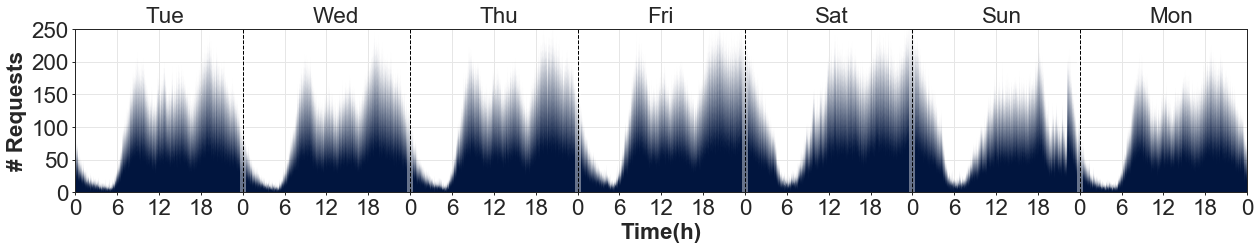

In [14]:
general_config = dict(replace=True,
                    smooth=None,
                    df = df_demand,
                    label_y = ([0, 50, 100, 150, 200, 250],[0, 50, 100, 150, 200, 250] , "x-large"),
                    print_details=False,
                    size_inches = (21,3),
                    fontsize="x-large",
                    fontsize_label="x-large",
                    custom_tw = ('2011-02-01T00:00:00', '2011-02-08T00:00:00'),
                    x_data_format = ('6h', '%H'),
                    color_bg = "#C0C0C0",
                    horizontal_legend = True,
                      style_plot = {'alpha':1, 'linewidth':0, 'colors' : [sns.xkcd_rgb['navy']]},
                    day_sep_config = (dict(linewidth=6, color='white', alpha=0.4), dict(linewidth=1, color='black', linestyle='--')),
                    fig_type = 'pdf',
                      context_font_scale = 1.3,
                    max_passenger = 4,
                    linewidth = 1)
msg_fontsize = 'large'
plot_vehicle_status_graph(trip_path,
                            "./",
                            "demand.png",
                            show_week_days = True,
                            show_service_rate = True,
                            show_tick_label_x = True,
                            show_day_separator = True,
                            print_details_axis = ("Time(h)", "# Requests"),
                            **general_config)